In [1]:
import numpy as np
from subprocess import getoutput
import requests
import sys
import ssl
import pandas as pd
from OpenSSL import crypto
import matplotlib.pyplot as plt
import pandas as pd
import os

In [36]:
filename = '/home/szlupek/Desktop/entropy.txt'
data = open(filename).read().splitlines()


In [40]:
data = np.array(data).astype(np.int32)
x = np.arange(len(data))/2
print(data)

[3811 3811 3812 ... 3254 3260 3266]


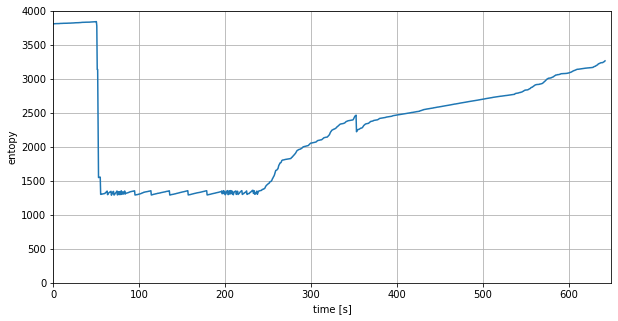

In [55]:
plt.figure(figsize=(10,5))
plt.plot(x,data)
plt.xlabel('time [s]')
plt.ylabel("entopy")
#plt.title('Wykres entropii w czasie przy generacji klucza GPG \n na sytemie Linux Mint 18')
plt.xlim(0,650)
plt.ylim(0,4000)
plt.grid()
plt.savefig('entriopia_NT.png')
plt.show()


# Scrapping data from webistes

In [5]:
keys_paths = os.listdir('keys')
keys_paths = ['keys/'+p for p in keys_paths]

['keys/pages_with_keys1000.csv',
 'keys/pages_with_keys3000.csv',
 'keys/pages_with_keys4000.csv',
 'keys/pages_with_keys5000.csv',
 'keys/pages_with_keys2000.csv',
 'keys/pages_with_keys9000.csv',
 'keys/pages_with_keys1.csv',
 'keys/pages_with_keys6000.csv',
 'keys/pages_with_keys7000.csv',
 'keys/pages_with_keys8000.csv']

In [50]:
pd_keys = [pd.read_csv(p, index_col = 0) for p in keys_paths]
pd_key = pd_keys[0]
for p in pd_keys[1:]:
    pd_key = pd_key.append(p)

In [51]:
del pd_key['Rank']

In [52]:
pd_key = pd_key.reset_index()

In [53]:
del pd_key['index']

In [76]:
pd_key.loc[pd_key['Key'].notnull()]

,Domain,OpenRank,Key
1,ucweb.com,6.45,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
3,aljazeera.net,6.44,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
4,dictionary.cambridge.org,6.44,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
5,elitedaily.com,6.44,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
6,cambridge.org,6.44,b'-----BEGIN PUBLIC KEY-----\nMFkwEwYHKoZIzj0C...
...,...,...,...
9994,mentalhealthcommission.ca,5.68,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
9995,blitz.gg,5.68,b'-----BEGIN PUBLIC KEY-----\nMFkwEwYHKoZIzj0C...
9997,justinbiebermusic.com,5.68,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
9998,letras.mus.br,5.68,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...


In [61]:
key_page = {}

In [62]:
for i, p in pd_key.iterrows():
    key_decode = p['Key']
    hostname = p['Domain']
    if key_decode in key_page:
        key_page[key_decode] = key_page[key_decode] + [hostname]
    else:
        key_page[key_decode] = [hostname,]

In [69]:
del key_page[np.nan]

In [81]:
list_keys = []

In [82]:
for i, k in key_page.items():
    list_keys.append([i, len(k)])

In [85]:
pd_no_keys = pd.DataFrame.from_records(list_keys)

In [94]:
keys_list = pd_no_keys.loc[:,1].values.tolist()

In [103]:
keys_list.sort()
keys_list = np.array(keys_list)

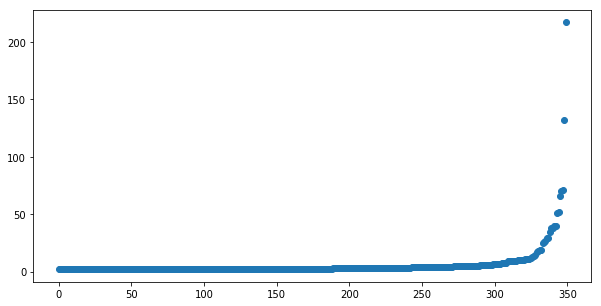

In [104]:
plt.figure(figsize=(10,5))
plt.plot(keys_list[keys_list>1], 'o')

In [114]:
print('domens:', np.sum(keys_list))
print('share key:', np.sum(keys_list[keys_list > 1]))
print('ratio:', np.sum(keys_list[keys_list > 1])/np.sum(keys_list))

domens: 6489
share key: 2144
ratio: 0.3304053012790877


In [110]:
pd_no_keys.loc[pd_no_keys.loc[:,1] > 1,:].sort_values(by=[1],ascending=False)

,0,1
43,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,217
57,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,132
650,b'-----BEGIN PUBLIC KEY-----\nMFkwEwYHKoZIzj0C...,71
70,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,70
115,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,66
...,...,...
1372,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,2
1423,b'-----BEGIN PUBLIC KEY-----\nMFkwEwYHKoZIzj0C...,2
1444,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,2
1445,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,2
